<h2>Importing Libraries</h2>

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import PorterStemmer
import re
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
import plotly.graph_objs as go
import plotly.tools as tls
from nltk.corpus import stopwords
import spacy
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import CountVectorizer

<h2>Reading Data</h2>

In [22]:
data=pd.read_csv("training_variants")
data_text=pd.read_csv('training_text',sep='\|\|',engine="python",names=["ID","TEXT"],skiprows=1)

In [23]:
DATA=pd.merge(data,data_text,on='ID',how='left')
DATA.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [24]:
print("Number of Data Points: ",DATA.shape[0])
print("Number of Data Features: ",DATA.shape[1])

Number of Data Points:  3321
Number of Data Features:  5


<h2>Text Preprocessing</h2>

In [25]:
nltk.download('stopwords')
Stop_words=stopwords.words("english")
def textpreprocess(x):
    x=str(x).lower()
    x=x.replace(",000,000","m").replace(",000","k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    string=""
    for word in x.split():
        if not word in Stop_words:
            string+=word+" "
    return(string)
    

[nltk_data] Downloading package stopwords to C:\Users\MD DANISH
[nltk_data]     ANWER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
DATA['TEXT']=DATA['TEXT'].apply(textpreprocess)

In [31]:
# Checking presence of Null Values
DATA[DATA.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT


<h2>Splitting DATA into Train, Test and Cross Validation test</h2>

In [36]:
y_true = DATA['Class'].values
X_train, X_test, y_train, y_test = train_test_split(DATA, y_true, stratify=y_true, test_size=0.15)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.15)

In [164]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 2398
Number of data points in test data: 499
Number of data points in cross validation data: 424


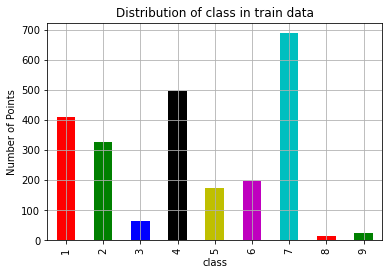

In [62]:
trainclassdist=X_train['Class'].value_counts().sort_index()
testclassdist=X_test['Class'].value_counts().sort_index()
cvclassdist=X_cv['Class'].value_counts().sort_index()
my_colors = ['r','g','b','k','y','m','c']
trainclassdist.plot(kind='bar',color=my_colors)
plt.xlabel('class')
plt.ylabel('Number of Points')
plt.title('Distribution of class in train data')
plt.grid()
plt.show()

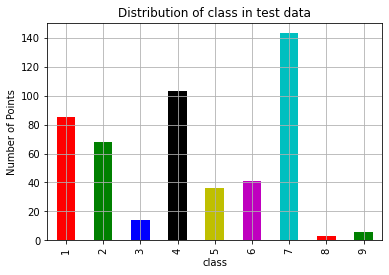

In [63]:
my_colors = ['r','g','b','k','y','m','c']
testclassdist.plot(kind='bar',color=my_colors)
plt.xlabel('class')
plt.ylabel('Number of Points')
plt.title('Distribution of class in test data')
plt.grid()
plt.show()

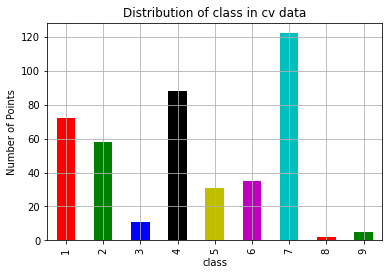

In [65]:
my_colors = ['r','g','b','k','y','m','c']
cvclassdist.plot(kind='bar',color=my_colors)
plt.xlabel('class')
plt.ylabel('Number of Points')
plt.title('Distribution of class in cv data')
plt.grid()
plt.show()

<h2>Building a random model</h2>

In [121]:
def plot_cm(test_y,predict_y):
     C = confusion_matrix(test_y, predict_y)
     A =(((C.T)/(C.sum(axis=1))).T)
     B =(C/C.sum(axis=0))
     labels = [1,2,3,4,5,6,7,8,9]
     print("Confusion Matrix")
     plt.figure(figsize=(20,7))
     sns.heatmap(C, annot=True, cmap="YlGnBu", xticklabels=labels, yticklabels=labels)
     plt.xlabel('Predicted Class')
     plt.ylabel('Original Class')
     plt.show()
     print("Precision Matrix")
     plt.figure(figsize=(20,7))
     sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
     plt.xlabel('Predicted Class')
     plt.ylabel('Original Class')
     plt.show()
     print("Recall Matrix")
     plt.figure(figsize=(20,7))
     sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
     plt.xlabel('Predicted Class')
     plt.ylabel('Original Class')
     plt.show()

Log loss on Cross Validation Data using Random Model 2.420356832926979
Log loss on Test Data using Random Model 2.5262686028100454
Confusion Matrix


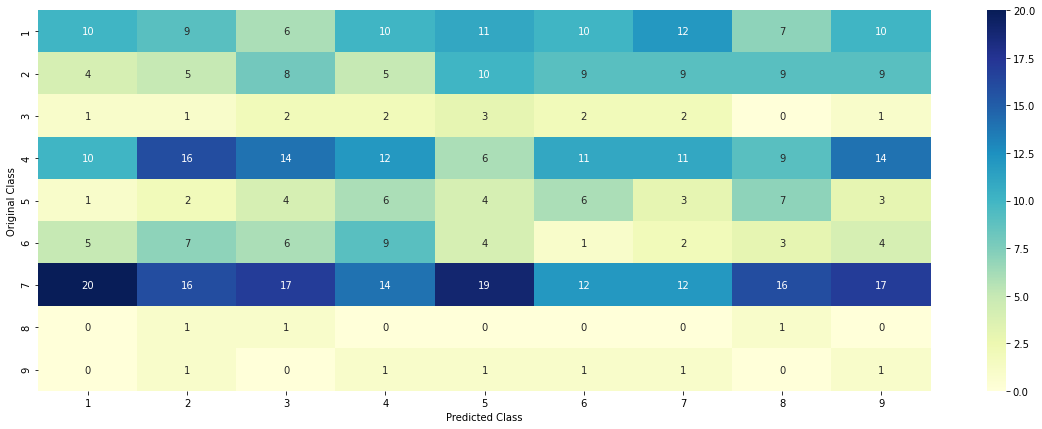

Precision Matrix


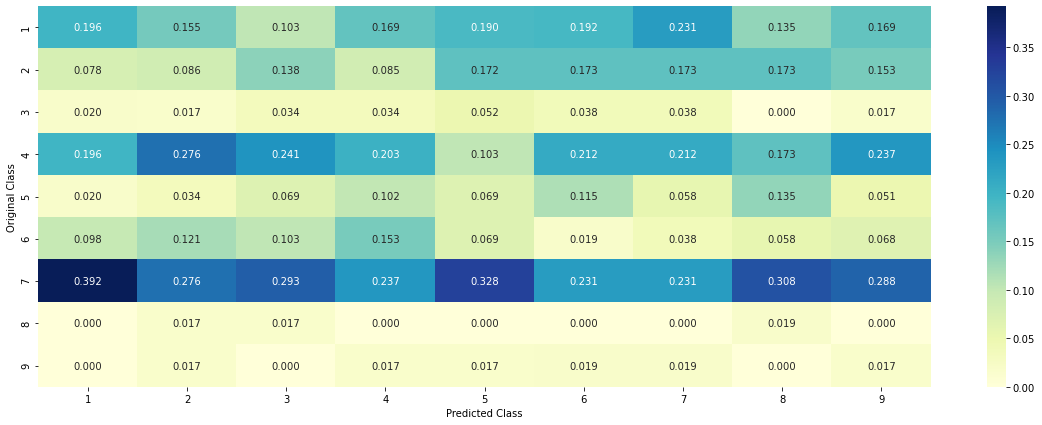

Recall Matrix


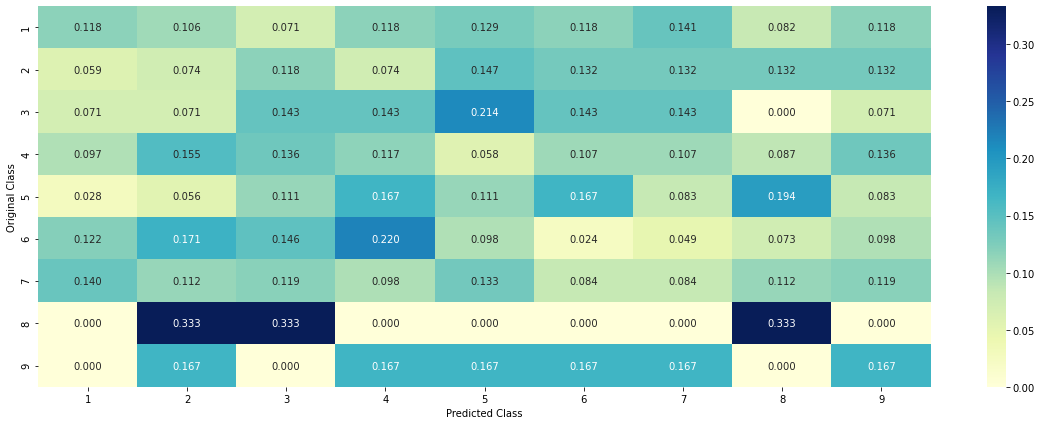

In [122]:
test_data_len=len(X_test)
cv_data_len=len(X_cv)
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = (rand_probs/sum(sum(rand_probs)))
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = (rand_probs/sum(sum(rand_probs)))
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))
predicted_y =np.argmax(test_predicted_y, axis=1)
plot_cm(y_test, predicted_y+1)

<h2>Univariate Analysis of Gene Feature </h2>

In [132]:
print("Number of Unique Gene Features: ",X_train['Gene'].value_counts().shape[0])
print("Top Gene Features: ")
print(X_train['Gene'].value_counts().head(10))

Number of Unique Gene Features:  240
Top Gene Features: 
BRCA1     190
TP53      123
EGFR       98
PTEN       93
BRCA2      89
KIT        73
BRAF       61
PDGFRA     47
ERBB2      47
PIK3CA     46
Name: Gene, dtype: int64


In [134]:
X_train['Gene'].value_counts().values

array([190, 123,  98,  93,  89,  73,  61,  47,  47,  46,  44,  39,  37,
        35,  34,  33,  32,  31,  30,  27,  27,  25,  24,  24,  23,  22,
        22,  22,  21,  19,  19,  18,  18,  17,  17,  17,  17,  16,  16,
        16,  16,  16,  14,  14,  14,  13,  13,  12,  12,  12,  12,  11,
        11,  11,  11,  11,  11,  10,  10,  10,   9,   9,   9,   9,   9,
         8,   8,   7,   7,   7,   7,   7,   7,   7,   7,   7,   6,   6,
         6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   5,   5,
         5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,
         5,   5,   5,   5,   4,   4,   4,   4,   4,   4,   4,   4,   4,
         4,   4,   4,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   1,   1,   

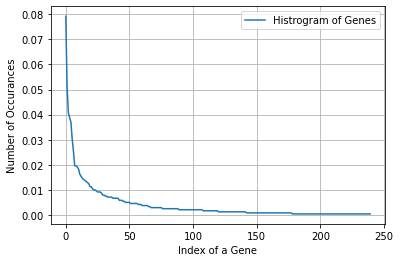

In [135]:
s = sum(X_train['Gene'].value_counts().values);
h = X_train['Gene'].value_counts().values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

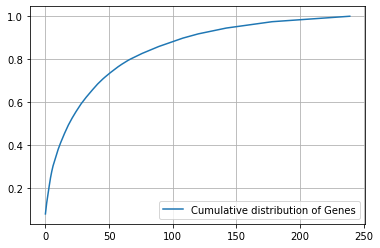

In [136]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

<h2>Univariate Analysis of variation Feature </h2>

In [141]:
print('Number of Unique Variations :', X_train['Variation'].value_counts().shape[0])
print(X_train['Variation'].value_counts().head(10))

Number of Unique Variations : 2170
Truncating Mutations    63
Amplification           56
Deletion                54
Fusions                 25
Overexpression           4
G12V                     4
Q61H                     3
Q61R                     3
I31M                     2
R841K                    2
Name: Variation, dtype: int64


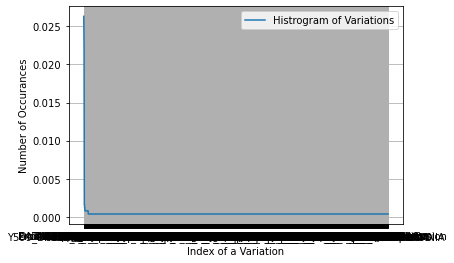

In [147]:
s = sum(X_train['Variation'].value_counts().values)
h =  X_train['Variation'].value_counts()/s
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

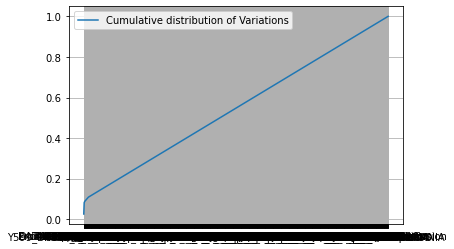

In [150]:
c = np.cumsum(h)
plt.plot(c,label='Cumulativdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAcYAAAEHCAYAAAA01uY4AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAgAElEQVR4nO3de5xVdb3/8ddnhqsgoKKEgIIeSPGSGnlhAkc7kqiFYaaevKAmmajZydQ6FXooJSsvWWJmmuYNNfOKmvFz0jmKImii4mUkHUcQAnUQFHCYz++P79ozi82eq2sxew3v5+OxH+y11ve71nftGfZnvtdl7o6IiIgEJR1dABERkWKiwCgiIhKjwCgiIhKjwCgiIhKjwCgiIhLTpaMLUIz69+/vQ4cObVfeDz74INnCiIhsQv369WtXvnnz5i13920TLk6HUGAsYOjQoTz77LPtynvvvfcmXBoRkU1nwoQJ7cpnZm8lXJQOo6ZUERGRGAVGERGRGAVGERGRGPUximRcSUkJ/fv3p1u3bh1dFOkEFi5c2OzxHj16MHjwYLp27bqJSrTpKTCKZFz//v3Zfvvt6dOnD2bW0cWRjGtuVKq7s2LFCmpqahg2bNgmLNWmpaZUkYzr1q2bgqJsEmbGNttsw5o1azq6KKlSYBTpBBQUZVPZHH7XFBgTdPOct3jzw44uhYiIfBoKjAm68L6XePF9faSy+Rk8ePAG27feeis/+MEPALj++uu5/fbbm8xbWVnJ008/nWr5NoVTTz2VsrIyrr766oZ9lZWVjBs3boN0dXV1jBgxgnfffbdV512yZAknnXRSs2mqq6u58847G7afe+45zj///DaUXuI0+CZBJWbU67nPIhs45ZRTmj1eWVlJr1692G+//TY6VldXR5cu7f+a+rT5W2vp0qU888wzLFiwYIP9o0eP5p133qG6upoddtgBgIqKCnbddVc+85nPtHjeuro6Bg4cyI033thsuurqau666y6OPvpoAPbee2/23nvvdt6NqHqToJISUFwU2dD06dO56qqrAPj973/P/vvvT1lZGaeccgrV1dXccMMNzJgxgzFjxvDkk09yxhln8D//8z985Stf4cILL2TBggUccsghlJWVcfzxxzesRzx//nzKysoYN24cP/nJTzjggAOAUFudNGkSxx57LBMnTmTVqlVMmDCBAw88kNGjRzNr1iwgBJN9992Xs88+mwMOOIDTTjuNiooKvvzlL/P5z3+eefPmbXQva9asYcqUKYwePZqxY8fyxBNPADBx4kSWL1/ecA85JSUlHHnkkdx9990N++6++26OOuoo5s2bx7hx4xg7dizjxo3j9ddfL1j+6urqhnurrq5m/PjxHHjggRx44IENNe2LLrqIp556ijFjxnD11VdTWVnJMcccA8D777/PN7/5TcrKyjjkkEN48cUXG34uZ555JkcccQR77bUXv//97wFYvXo1hx9+OJ/73OfYfffdmTlzZhK/BpmiGmOCVGOUjnbp3xfx6tLViZ7zswN6cd5/7tRsmo8//pgxY8Y0bL///vuMHz9+o3RXXHEFzz//PN27d6e2tpa+ffty8skn06tXL8466ywAbr75ZqqqqrjnnnsoLS2lrKyMSy+9lLKyMi6++GJ+8YtfcMkllzBlyhSuuOIK9ttvPy688MINrjN37lwqKyvZaqutqKur489//jN9+vRhxYoVHHLIIQ1lW7RoETfccANXXHEFBx98MHfddRcPP/wwDz30EJdddhm33HLLBue97rrrAHjyySd57bXXmDhxIs8++yy33XYbxxxzTEOgjDvqqKM455xzOOecc1i7di2PPvooF198MSUlJcyaNYsuXbpQUVHBtGnTuOmmmzYqf3V1dcO5+vfvz1//+ld69OjBG2+8wbe+9S0ee+wxpk6dylVXXdUQxCorKxvyXHLJJey5557ccsstPP7443znO99pKOdrr73G/fffz6pVq/jCF77AKaecwuzZs9l+++158MEHAaitrW32Z98ZKTAmqNRMNUbZLPXs2XODoHDrrbfy3HPPbZRut912Y/LkyRx22GEcfvjhTZ7vyCOPpLS0lNraWmpraykrKwPguOOOY9KkSdTW1rJq1aqG5tevf/3rPPLIIw35y8vL2WqrrYAw927atGk8+eSTlJSUsGTJEpYtWwbAjjvuyG677QbALrvswtixYzEzRo4cuUFAypkzZw6TJ08GYMSIEQwZMoSqqir69OnT5L3ss88+rF69mtdff53XXnuNUaNG0a9fP2pqajjjjDN44403MDPq6uoKlj/uk08+4bzzzmPBggWUlpbyxhtvNHndeJlzAXfs2LG89957DcFu3LhxdO/ene7du7PtttuybNky9thjD84991zOP/98jjjiiA3+4NlcKDAmyAxckVE6UEs1u442c+ZMnnzySR566CF+9atf8dRTTxVMt8UWWzR7Hm/hP1o8/5133smKFSuoqKiga9eu7LnnnqxduxZgg9WCSkpK6N69e8P7eKBq7XWbMnHiRO6++25effVVjjrqKAAuvvhixowZw80330x1dTVHHHFEwfLHzZgxg+22247Kykrq6+tb1U9ZqMy5KRe5+4Vwz+vXr2e33XZj3rx5zJo1ix/+8IeMGzeOn/70p22636xTH2OCSktMgVGkCfX19bzzzjuMGTOGiy66iNraWlavXk3v3r1ZtWpVwTx9+/alX79+Df12M2fOpKysjH79+tG7d2/mzp0LsEEfXr6VK1fSv39/unbtyhNPPMHbb7/d7nsYPXp0w+jPqqoqampqGD58eIv5jjrqKO644w6eeOKJhmbclStXMnDgQCDUsFtj5cqVDBgwgJKSEmbOnMn69esBmv0M42WurKxkm222abaGu3jxYrbYYguOP/54zj33XObPn9+qsnUmRRMYzexQM3vVzKrM7IICx83MfhMdf8HM9on2DzGzx8xsoZm9ZGbfjeW50MzeMbPno9dhad5DiRn1aV5AJMPWr1/P5MmTGwaufOc736Fv374ceuihPPDAAxsNXMmZMWMGU6dOpaysjAULFnDeeecBcNVVV3HOOecwbtw43L3JL/ujjz6a559/noMOOog777yTESNGtPseTj31VNavX8/o0aM55ZRTuPrqqzeodTVll112oWfPnowZM4ZevXoBcPbZZ/O///u/fPnLX24IcK25/m233cYhhxxCVVVVw7l22203unTpwhe/+MUNposAXHDBBTz33HOUlZVx0UUXbXQ834IFC9h3333Za6+9+PnPf86Pf/zjVpWtM7H2Ng0kWgizUuA14BCgBpgLHOfuL8fSHAacBRwG7Adc6e77mdlAYKC7zzezLYF5wJHu/rKZXQiscvdftaU8o0aN8vY8qPgLP/87w3t+zDE7KzzKpjN48GB23nnnji7GJrdq1Sp69+4NwOWXX87SpUuZPn16B5cq+5pbKzVn4cKF7LrrrhvsM7N57j4qrXJtSsXSx7gvUOXuiwDM7HZgAvByLM0E4CYPkXyOmfUzs4HuvgRYAuDuH5rZQmBQXt5NosRQjVFkE/nb3/7G5ZdfTl1dHUOGDGmxJiTSWsUSGAcB8Yb/GkKtsKU0g4iCIoCZDQX2BuLLaJxpZicCzwLfd/f3CxXAzCYDkwEGDBhARUVFm2/ik3Xr8JZbVUQkARMnTmTixIkdXYxO58MPW17Xcs2aNe36jsyKYgmMhValzW/jbTaNmfUG/gKc4+4ro90zgGlRumnAr4GCy3C4+7XAtRCaUsvLy9tQ/KDnnP9HPcnOIRNpDXffLBZ3lvRtueWWzR53d3r06NGpV9YplsE3NcCQ2PZgYHFr05hZV0JQvMXdG4anuftSd1/v7vXAHwhNtqnRqFTpCOvWrWPlypXtnkog0lq55zH26NGjo4uSqmKpMc4FhpvZMOAd4Fjgv/LS3EdoFr2d0Mxa6+5LLPyZ/EdgobtfFs8Q64ME+BrwYpo3UWJo5RvZ5JYvX77BvyKfRktzSHv06LHRovGdTVEERnevM7MzgUeAUuB6d3/JzE6Pjl8DzCKMSK0CPgJOjrKXAScAC8zs+Wjfj9x9FnCpme1FaEp9E/h2mvdRUmK4Rt/IJlZfX9+wkovIpzVhwoSOLkKHK4rACBAFsll5+66JvXdgSoF8lRTuf8TdT0i4mM0qMTWliohkXbH0MXYKpZrgLyKSeQqMCdJaqSIi2afAmKDSEj1dQ0Qk6xQYE6TnMYqIZJ8CY4JKVGMUEck8BcYEaR6jiEj2KTAmqNRUYxQRyToFxgSpj1FEJPsUGBNUUgLuWshZRCTLFBgTVKIJ/iIimafAmCA9XUNEJPsUGBNkGnwjIpJ5CowJKtV0DRGRzFNgTJBqjCIi2afAmCCNRxURyT4FRhERkRgFxgSZqowiIpmnwJgwTdcQEck2BcZEqcooIpJ1CowiIiIxCowJUh+jiEj2KTAmTF2MIiLZpsCYIFUYRUSyT4FRREQkRoExYWpKFRHJNgXGBGnwjYhI9ikwJk1VRhGRTFNgTJBp+I2ISOYlHhjN7FIz62NmXc1stpktN7Pjk75OsVKFUUQk29KoMY5z95XAEUANMAL4QUuZzOxQM3vVzKrM7IICx83MfhMdf8HM9on2DzGzx8xsoZm9ZGbfjeXZ2sweNbPXo3+3Su42C91DmmcXEZFNIY3A2DX69zDgNnd/r6UMZlYK/A4YD4wEjjOzkXnJxgPDo9dkYEa0vw74vrvvCuwPTInlvQCY7e7DgdnRtoiISJPSCIz3m9krwChgtpltC6xpIc++QJW7L3L3dcDtwIS8NBOAmzyYA/Qzs4HuvsTd5wO4+4fAQmBQLM+N0fsbgSM/7c01RzVGEZHs65L0Cd39AjP7BbDS3deb2UdsHOTyDQLejm3XAPu1Is0gYEluh5kNBfYGno52DXD3JVG5lpjZdk0VwMwmE2qiDBgwgIqKihaKvLFly9aoj1FEMq09332dTeKB0cy2AKYAOxACzfbAZ4EHmstWYF9+jGk2jZn1Bv4CnBP1cbaJu18LXAswatQoLy8vb+spuPOd+by9cnGb84mIFIv2fPd1Nmk0pd4ArANGR9s1wM9ayFMDDIltDwbyI0yTacysKyEo3uLud8fSLDWzgVGagcCy1t+GiIhsjtIIjDu7+6XAJwDu/jEtr689FxhuZsPMrBtwLHBfXpr7gBOj0an7A7VR86gBfwQWuvtlBfKcFL0/Cbi33XclIiKbhcSbUoF1ZtaTqJnTzHYG1jaXwd3rzOxM4BGgFLje3V8ys9Oj49cAswgjXauAj4CTo+xlwAnAAjN7Ptr3I3efBUwH7jCzU4Fq4OjkbrMADb4REcm8NALjVOBhYIiZ3UIIXJNayhQFsll5+66JvXdC32V+vkqaCEnuvgL4UhvK/qm5Rt+IiGRaGqNSHzWz+YQ5hQZ8192XJ32dYqQKo4hI9qWxJNzXgDp3f9DdHwDqzCzV+YMiIiJJSWPwzVR3r81tuPsHhObVTs80w19EJPPSCIyFzplGX2ZRUhejiEi2pREYnzWzy8xsZzPbycwuB+alcJ2io/qiiEj2pREYzyJM8J8J3ElYJ3Wj0aQiIiLFKI1RqavZjJ9ioaZUEZFsS2Ot1BHAucDQ+Pnd/eCkr1VsNPZGRCT70hgUcydwDXAdsD6F8xc3VRlFRDItjcBY5+4zWk7W+ajCKCKSfWk9qPgMMxtoZlvnXilcpyipwigikm1p1BhzT7P4QWyfAzulcK2iogn+IiLZl8ao1GFJn1NERGRTSWVFGjPbHRgJ9Mjtc/eb0rhWMVF9UUQk+9KYrjEVKCcExlnAeKAS6PSBEdTHKCKSdWkMvvk64RmI77r7ycDngO4pXKf4qMooIpJ5aQTGj929nvC4qT7AMjaDgTciItI5pNHH+KyZ9QP+QFg8fBXwTArXERERSVyigdHCfIVLomcwXmNmDwN93P2FJK9TrExtqSIimZdoU6q7O3BPbPvNzSUo5rhG34iIZFoafYxzzOwLKZy36Gl+v4hI9qXRx3gQ8G0zewtYTRir6e6+ZwrXKjqqMIqIZFsagXF8CufMBFUYRUSyL43AqEqTiIhkVhqB8UFCcDTCknDDgFeB3VK4VlFRH6OISPalsYj4HvFtM9sH+HbS1ylWqi6LiGRbGqNSN+Du84HNYpSq5jGKiGRfGouI/3dsswTYB/h30tcRERFJQxp9jFvG3tcR+hz/ksJ1ipPaUkVEMi2NPsaL2pPPzA4FrgRKgevcfXrecYuOHwZ8BEyKmmkxs+uBI4Bl7r57LM+FwGk01lh/5O6z2lO+1t1DWmcWEZFNJfE+RjN7NFpEPLe9lZk90kKeUuB3hDmQI4HjzGxkXrLxwPDoNRmYETv2J+DQJk5/ubvvFb1SC4o5qjCKiGRbGoNvto0WEQfA3d8Htmshz75Albsvcvd1wO3AhLw0E4CbPJgD9DOzgdE1HgfeS+wO2kk1RhGR7EsjMK43sx1yG2a2Iy1XpAYBb8e2a6J9bU1TyJlm9oKZXW9mW7UivYiIbMbSGHzzP0Clmf0j2h5LaPpsTqG6Vn4wbU2afDOAaVG6acCvgVMKFsBsMlE5BwwYQEVFRQun3tiSxWvbnEdEpJi057uvs0lj8M3D0aT+/QnB7HvuvryFbDXAkNj2YGBxO9Lkl2Vp7r2Z/QF4oJm01wLXAowaNcrLy8tbKPLGHnlvAb70rTbnExEpFu357uts0hh88zXgE3d/wN3vB+rM7MgWss0FhpvZMDPrBhwL3JeX5j7gRAv2B2rdfUkLZRkY2/wa8GKbbqaN1McoIpJ9afQxTnX32txGNBBnanMZ3L0OOBN4BFgI3OHuL5nZ6WZ2epRsFrAIqAL+AJyRy29mtwFPAZ81sxozOzU6dKmZLTCzFwiPw/peIncoIiKdVhp9jIWCbYvXiaZSzMrbd03svQNTmsh7XBP7T2jpuknTdA0RkWxLo8b4rJldZmY7m9lOZnY5MC+F6xQdtaSKiGRfGoHxLGAdMBO4E1hDEzW9TklVRhGRTEtjVOpqM/sZMM3dVyd9/mKmwTciItmXaI3RzM4ws2rgLaDazN4yszNayteZqMIoIpJtiQVGM/sxYSHvcnffxt23IYwEHR8d6/T0PEYRkexLssZ4AjDR3RfldkTvvwGcmOB1REREUpNoU6q7rymw72OgPsnrFCv1MYqIZF+SgbHGzL6Uv9PMDgaaXaGmM1Efo4hItiU5KvVs4F4zqyTMW3TgC0AZGz9CqlNShVFEJPsSqzG6+0vA7sDjwFBgp+j97tExERGRopfoPMaoj/H6JM+ZOWpLFRHJtDRWvtlsmUbfiIhkngJjwlRhFBHJtiQn+M+O/v1FUucUERHZ1JLsYxxoZgcCXzWz28kbpOnu8xO8loiISCqSDIw/BS4ABgOX5R1z4OAEr1WU1MUoIpJ9iQVGd78LuMvMfuLu05I6b9aoj1FEJNvSeOzUNDP7KjA22lXh7g8kfZ1ipEXERUSyL/FRqWZ2CfBd4OXo9d1o32ZBNUYRkWxLvMYIHA7s5e71AGZ2I/Ac8MMUrlVU1McoIpJ9ac1j7Bd73zela4iIiCQujRrjJcBzZvYYYcrGWDaD2mIDtaWKiGRaGoNvbjOzCsKTNQw4393fTfo6xUgtqSIi2ZdGjRF3XwLcl8a5i50qjCIi2aa1UhOkwTciItmnwCgiIhKTaGA0sxIzezHJc2aJHjslIpJ9iQbGaO7iP81shyTPmyXqYxQRybY0Bt8MBF4ys2eA1bmd7v7VFK5VVFRfFBHJvjQC40XtyWRmhwJXAqXAde4+Pe+4RccPAz4CJuUeZWVm1wNHAMvcffdYnq2BmcBQ4E3gG+7+fnvKJyIim4fEB9+4+z8IQahr9H4u0OyzGM2sFPgdMB4YCRxnZiPzko0HhkevycCM2LE/AYcWOPUFwGx3Hw7MjrbTpbZUEZFMS2MR8dOAu4DfR7sGAfe0kG1foMrdF7n7OuB2YEJemgnATR7MAfqZ2UAAd38ceK/AeScAN0bvbwSObOv9tInaUkVEMi+N6RpTgDJgJYC7vw5s10KeQcDbse2aaF9b0+QbEC02kFt0oKVyfGqqMIqIZFsafYxr3X1dbuqCmXWh5XhRqK6Vn6c1adrNzCYTmmgZMGAAFRUVbT7H29XrkiqOiEiHaM93X2eTRmD8h5n9COhpZocAZwD3t5CnBhgS2x4MLG5HmnxLzWyguy+Jml2XNZXQ3a8FrgUYNWqUl5eXt3Dqjc35+BX8zao25xMRKRbt+e7rbNJoSr0A+DewAPg2MAv4cQt55gLDzWyYmXUDjmXjtVbvA060YH+gNtdM2oz7gJOi9ycB97b+NtpO8/tFRLIvjadr1EcPJ36a0NT5qrs32+Tp7nVmdibwCGG6xvXu/pKZnR4dv4YQYA8DqgjTNU7O5Tez24ByoL+Z1QBT3f2PwHTgDjM7FagGjk70ZkVEpNNJPDCa2eHANcAbhH7BYWb2bXd/qLl87j6LEPzi+66JvXfCwJ5CeY9rYv8K4EttuoFPQRVGEZHsS6OP8dfAQe5eBWBmOwMPAs0Gxs5Co1JFRLItjT7GZbmgGFlEM4NeOhP1MYqIZF9iNUYzmxi9fcnMZgF3ECpQRxMG14iIiBS9JJtSvxJ7vxQ4MHr/b2CrBK9T3NSWKiKSaYkFRnc/ueVUnZtp+I2ISOalMSp1GHAW4YkWDeffHB47BaowiohkXRqjUu8B/khY7aY+hfMXLQ2+ERHJvjQC4xp3/00K5xUREUldGoHxSjObCvwNWJvbmXuocGemCqOISPalERj3AE4ADqaxKdWj7U7PFR5FRDItjcD4NWCn6IHDmxd1MoqIZF4aK9/8E+iXwnlFRERSl0aNcQDwipnNZcM+xk4/XUP1RRGR7EsjME5N4ZwiIiKbRBrPY/xH0ufMGnd1N4qIZFUaK998SOMCMN2ArsBqd++T9LWKjYKhiEj2pVFj3DK+bWZHAvsmfZ1i5qi/UUQkq9IYlboBd7+HzWQOoxYRFxHJvjSaUifGNkuAUWhtbRERyYg0RqXGn8tYB7wJTEjhOkVHfYwiItmXRh/jZv9cRlWPRUSyK7HAaGY/beawu/u0pK5VrFRhFBHJviRrjKsL7OsFnApsA3T6wCgiItmXWGB091/n3pvZlsB3gZOB24FfN5WvU9J8DRGRzEq0j9HMtgb+G/gmcCOwj7u/n+Q1ipkG34iIZF+SfYy/BCYC1wJ7uPuqpM6dNRp8IyKSXUlO8P8+sD3wY2Cxma2MXh+a2coEr1O0TFVGEZHMS7KPMfVVdERERNKmYCYiIhKjwJgC9TGKiGRX0QRGMzvUzF41syozu6DAcTOz30THXzCzfVrKa2YXmtk7ZvZ89Dos3XtI8+wiIrIpFEVgNLNS4HfAeGAkcJyZjcxLNh4YHr0mAzNamfdyd98res1K904CV5VRRCSziiIwEp7XWOXui9x9HWFRgPyFxycAN3kwB+hnZgNbmXeT0GOnRESyL42na7THIODt2HYNsF8r0gxqRd4zzexE4Fng+00tOGBmkwk1UQYMGEBFRUWbb2LRonVtziMiUkza893X2RRLYCxU1cpvkGwqTXN5ZxDWaPXo318DpxQqgLtfS1icgFGjRnl5eXmLhc63kDfgtVfanE9EpFi057uvsymWwFgDDIltDwYWtzJNt6byuvvS3E4z+wPwQHJF3pgG34iIZF+x9DHOBYab2TAz6wYcC9yXl+Y+4MRodOr+QK27L2kub9QHmfM14MW0bwQ0XUNEJMuKosbo7nVmdibwCFAKXO/uL5nZ6dHxa4BZwGFAFfAR4ckdTeaNTn2pme1FiFVvAt9O8z5UYRQRyb6iCIwA0VSKWXn7rom9d2BKa/NG+09IuJgiItLJFUtTaqegPkYRkexTYEyB+hhFRLJLgTFBmuAvIpJ9CoxpUJVRRCSzFBgTpD5GEZHsU2AUERGJUWBMgVpSRUSyS4FRREQkRoExBaoxiohklwJjgkyjb0REMk+BUUREJEaBMUGqL4qIZJ8CYwpcnYwiIpmlwJggdTGKiGSfAqOIiEiMAqOIiEiMAmOC1JIqIpJ9Cowp0NgbEZHsUmBMkCb4i4hknwJjgj7+ZD0A/17TwQUREZF2U2BM0N5D+gGwdr1qjiIiWaXAmKBe3bsAsK6+gwsiIiLtpsCYoL49uwJQVasao4hIVikwJmjI1lsAUKpPVUQks/QVnrBeXZx16zu6FCIi0l5dOroAnU33UnhqmTF/eSkAu/RzThqhTkcRkaxQYEzYV3eoZ9GHoY/x9VqjaqX6G0VEskSBMWF793f27h/Wvrn7zRLmLFNgFBHJEgXGFHUvCXMaf/uSunJFpPht2RUmdHQhikDRBEYzOxS4EigFrnP36XnHLTp+GPARMMnd5zeX18y2BmYCQ4E3gW+4+/ub4n4ARm4VmlXXu2qNIlL86vSUdaBIAqOZlQK/Aw4BaoC5Znafu78cSzYeGB699gNmAPu1kPcCYLa7TzezC6Lt8zfVfQ3bEs7aTUNURUSypFja+PYFqtx9kbuvA25n4xr9BOAmD+YA/cxsYAt5JwA3Ru9vBI5M+0ZERCTbiqLGCAwC3o5t1xBqhS2lGdRC3gHuvgTA3ZeY2XZNFcDMJgOTAQYMGEBFRUXb70JEJOP03Vc8gbFQJ1x+Y3dTaVqTt0Xufi1wLcCoUaO8vLy8racA4N57721XPhGRYtDe777OpFiaUmuAIbHtwcDiVqZpLu/SqLmV6N9lCZZZREQ6oWIJjHOB4WY2zMy6AccC9+WluQ840YL9gdqombS5vPcBJ0XvTwJUnRMRkWYVRVOqu9eZ2ZnAI4QpF9e7+0tmdnp0/BpgFmGqRhVhusbJzeWNTj0duMPMTgWqgaM34W2JiEgGFUVgBHD3WYTgF993Tey9A1NamzfavwL4UrIlFRGRzqxYmlJFRESKgrlWOtiImf0beKud2fem8EhZEZFitx74Zzvz7uju2yZZmI6iwJgwM9MHKiKZ5a41LNWUKiIiEqPAKCIiElM0o1I7kVVA1yaOlRLa8JuS5vGOvPbmfryYy9bZjxdz2Yrx+IfNpN1sqI9RREQkRk2pIiIiMQqMIiIiMYn2McamKnj0WupGio8AAAvVSURBVAb8ErjC3evNrBx4DPiqu99vZtsA/wK6A90KnPJ9YCvgH8CB0b5/AcOAejYO7E09bUNERNL3BvA0cAzwOiHGdAdGAfsDI4G/AycSlvWsJ3ynAyx39/9sy8XM7KvASHefnkjpc9y9yRchyFQC42P7vgE8DLwJLACeB56NjjlhHdOngA+AVwiB8CJC4HsYWAesBsqjPA8A5cCFwN+Al4FF0bk+JnQM1wH/jvatif27PnrlthfTGJTjr0L765tIq5deeumlV/tedcCV0b/LgVrC9/jT0ff9J8A7hO/tKsJgn9XADoTn6johtrwa5c99768Dnov2rQe+GYtJqwq9j7a/R4gNfZuLdfmvFgffmNnuwJ2EFV1KCYHwUGA2MMrdl8fSOiHgHAzsSgiiq4CvAC8SanorgV5AD0Lw3BJ4F1gB7Aj0z50u+kByNcCPgZ40X1OMpxcRkU0v/j28llBjbE3auBXA1nnHVhICZL8o33jCIwevdfduZrYjocb6MiGgngzcRYgrLxDizmeA89z9ruZuoMU+Rnd/EbgfOB+YCtzk7m+0cM4rgV8AS4E9o/0DgUeBPsD/Ef5yeDe68QuA3QhBsj52rsejf9fSOAWiUJnrCX+hfNLUbTRTXhERSU48mOWCYnxKyJom8sW/v7vR+Pzc3P7ewELg54Sa5vfy8v8WqHP3PYFbgOuiPPOBPYAvAkcQnrrUrNYOvrkI+C9ChL402ufA38xsnplNzkvfB7gpKtB2hKD1OnA4oan1ZmALQnT/KCr8ckKAW0cIhNBYe/yExqbPQkoJbdmF+ilBtUgRkU2lrsC+0tj7+NiWeMC8n8bv+O40PnC+Ntr/MfA5YATwF2C/vGscELv2n4Ey4DZCBa0U6O/uLwMDWrqBVgVGd18NzAT+7O65oFXm7vsQguUUMxsb7f+I0HY8mhD86mhse64jVI+nEP4a+HzepboRPpDcXxmfjf7tHd1YcwGuntBsW8jHLdyiiIgko9D3dFOVmniQHBF735UQBCEMzqkn1BJrgcGE7ry+hC65pnQHbo/ez6HxebwtVpTaMl2jnlgzp7svjv5dBvwV2LfxkI9z988TBtuUEG5mIaE59hNCx+oHhBphX0LbcW5V9vdpDGSVhA90FVBToDw5uap2z1wZ8tIW+gtGRESSVyjwrGri+Ac0fpcPih17n8b4tCehYrQ1oeL1ACFuvMmGz9t9ksZAe350rkeBrxNqj8e19gbaNY/RzHqZ2Za598A4wuAagF5m9rGZfQxURPt7AD8mNKe+C4wldJp+QrjhS4H3CDcdtw3h5lZG6aHxQ4yXvWuUrjQvTc6W7blPERFps0Jxpanv4L40BsOt8tKvi94/S2Os2Ak4j9AEez5hRkPuemcDXczsBeBbwC/dfShhAM5kYFA0QKddN9AaA4BKM/sn8AzwoLs/HD2u5BzCsNu3CYNwDnD3LQnNqlcSOl7fJMw96efu5u47ufsgd+/r7v3dvRfheYgGvESocU4Herp7KWF47zjCdJFXCX+NHB2leZ3GD/RDwmik1wmjlFZE+3N9li/Q+JfMB4S26I8INd2jgXlRunspXOvM9Ynm8+hcNHFcRCTLllP4u20tjX2D8XEhHnu/mPA9u5TwHV1PiAv/InwfrySMP5kQxZRcy+G7hIC4EjjJ3f9K6EssBXD3N4E10eAbB/4U7Z8UjUL9K3Csu/du8e7aMrejM70Iwbl/3r4/AV+PbR9DmJ7yIvBI9MN6Ktq3PPolWBv9YGcRrT3bzDX/SJj8umNry9TOe3uIMJ2mb97+vxL+GOj/aa9J+EvtgQL7/0Roupge/eL/kzCf9YfNnOsqQr/0CMJ81nOj/RWEKUFN3lMCn9W66Of5CvCbln6GTZzjRMIfgkcX+L15ENi2rZ9jgXSTgN/Gfmb7Rb+Pp0X/HtZEvobPsInjDZ93K8owFHgxtj2a8Afs51vIl8jvdd45W3vtZtPl/59vxXVHEbqFmvx9bsO5pkQ/u/qW7qMd5/5M9Dt4OiF43NKe3+3W/k52tpcWES8iZvYmeXNDi/Wa0SpG57r7EQmX50LCJN1fJXnerDOzSYSf05lJ/p605fM2s6GEIL57G6/xJpv49zpLzGyVt6YWU2Tiv5MdXZakdXhgNLOn2XgC6AnuvqAjygNgZicD383b/X/uPiWW5neEDt1S4D+i3f8m9JVCY6fw7AKXWM+Gw5chuufYeeOuJPzlN5DGQUrdCbWdVYSJqxCanrvRuNgBee8h/HVaRWi6+JK7r4juZ5smytqQJko3m/BXOIS+3RJC03ZubmuurLmfae7zeSvazrXxV0WfQ27kcdyT7t7QqW5mexDVvPLu4095P5OCPzdCH0V8fynhL+p3CQtR5LoUciOuf+Duv42d92FC032hQQW1wC25csQ+xwGEicg5VYQRctsTFrwYHDtfbpLzekIzf7fYsXgaCLXwpWz8ub0b5R1C488l97NfS2i6qid0aeTut2uU5y0a55bl/7xPJswPi3e7fBSduycb+gFwAuFnP4gwmpzo/MNi95ibXvUBjX1MTuGundx9v0H4Pcv9jLoTPuPc0Pt1bPi5xX0C/Hf8Z1pI9Ht2KzC8iXPlFjBZT/js1tH4mKauhJpxzpXufkPs3PHvueGEe30rKtt/ROfu0UT54/9/6wjdR10Jv199Y8fqgYvd/efN3ae0rMMDo4iISDHR0zVERERiFBhFRERiFBhls2JmTa2O1FT6cjN7IMXydDezv5vZ82Z2TBvzDjWzGjMrydv/vJnt21S+Aud5soXj/czsjNj29mbW7CLMIlmmwCjSsfYGurr7Xu4+sy0ZPczbehsYk9tnZrsAW7r7My3lN7Pc/K/RLSTtBzQERndf7O5fb0tZRbJEgVE2S1FNsMLM7jKzV8zsFjOz6Nih0b5KYGIsTy8zu97M5prZc2Y2Idr/GzP7afT+y2b2eIFa3NZmdo+ZvWBmc8xsTzPbjrCg/l5RLW/nvDynRdf6p5n9xcy2KHArtwHHxraPBW6LapNPmNn86DU6dt+PmdmthAUyGmrRZtbbzGZH6Rfk7o8wJ3XnqIy/jM79YpSnh5ndEKV/zswOivZPMrO7zexhM3vdzC5FJCs6eiKlXnptyhfRg0wJE+tzCxKXEBZu+CJhyPzbhCH1BtxBNAEfuBg4PnrfD3iNMFVmC8IKTQcRhtLvXOC6VwFTo/cHA8/HylFwgj+wTez9z4CzCqT5DLAE6BJtLwR2j8rUI9o3nMaHiZcTpj0MK/CZdAH6RO/7E6aYGBtP7G/YBr4P3BC93wWojj7DSYQHjucWen4LGNLRP3+99GrNK76yucjm5hl3r4HQL0f4wl8F/MvdX4/230xYZxHCXMavmtm50XYPYAd3X2hmpxGeH/o9L/y80i8CRwG4+/8zs23MrG+BdHG7m9nPCEG4N2H1pQ24+7tm9hLwJTNbCnzi7i9G5/6tme1FmHcXf3LBM+7+rwLXM+Di6Ek59YS5iC09oueLhKCPu79iZm/FrjXb3WsBzOxlwhzWt1s4n0iHU2CUzdna2Pv1NP5/aGpyrwFHufurBY7tQViLd/tm8uZraRLxn4Aj3f2f0Soj5U2kyzWnLo3eQ3iI61LCo3tK2PDhsKubOM83CYsofN7dP4lWrGnusT7Q/CN8mvp8RYqa+hhFNvQKMCzW3xd/VM0jwFmxvsi9o393JDQp7g2MN7P8B6hCqE1+M0pfDix395UtlGVLYImZdc3lbcJfgMMIa7Tmnj/XF1ji7vWE1WjyV1oqpC+wLAqKB9G4StGHNP10hPh9jQB2IDQni2SWAqNIjLuvITSdPhgNvnkrdngaYSmuF6LBJ9OiIPlHwrqxi4FTgevMLL+mdSEwysIjcaYDJ7WiOD8hLDr/KCFgN1XmDwgPYl0aayK9GjjJzOYQmjabqiXG3RKV8VlCsHslOv8K4P/M7EUz+2VenquBUjNbQHiY+SRvfJi5SCZpSTgREZEY1RhFRERiFBhFRERiFBhFRERiFBhFRERiFBhFRERiFBhFRERiFBhFRERi/j+OJfxT6GYTygAAAABJRU5ErkJggg==e distribution of Variations')
plt.grid()
plt.legend()
plt.show()

<h2>Feature Engineering of Gene, Variation and Text features</h2>

<h3>Response Coding</h3>

In [165]:
def responsecoding(alpha,feature,df):
    value_count=X_train[feature].value_counts()
    dic=dict()
    res_feat=[]
    for i,den in value_count.items():
        vec=[]
        for k in range(1,10):
            cls_cnt=X_train.loc[(X_train['Class']==k) & (X_train[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (den + 90*alpha))
        dic[i]=vec
    for index,row in df.iterrows():
        if row[feature] in dic.keys():
            res_feat.append(dic[row[feature]])
        else:
            res_feat.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return res_feat

In [166]:
alpha = 1
train_gene_feature_responseCoding = np.array(responsecoding(alpha, "Gene", X_train))
test_gene_feature_responseCoding = np.array(responsecoding(alpha, "Gene", X_test))
cv_gene_feature_responseCoding = np.array(responsecoding(alpha, "Gene", X_cv))

In [170]:
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(X_train['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(X_test['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(X_cv['Gene'])
    
    

In [171]:
alpha = 1
train_variation_feature_responseCoding = np.array(responsecoding(alpha, "Variation", X_train))
test_variation_feature_responseCoding = np.array(responsecoding(alpha, "Variation", X_test))
cv_variation_feature_responseCoding = np.array(responsecoding(alpha, "Variation", X_cv))

In [172]:
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(X_train['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(X_test['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(X_cv['Variation'])